We can also place human in the loop and reduce number of iterations

In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [2]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  no_of_iterations: int

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=5)]

In [4]:
from langchain_core.messages import (
    HumanMessage
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

In [5]:
search_template = """Your job is to search the web for stock market related news that would be relevant to to generate the article described by the user.

                     NOTE: When providing the news articles retrieved to the Outliner, you need to give the Outliner all of the articles you have retrieved that are relevant.
                     The format should be:

                     1. <article 1>
                     2. <article 2>
                     ...
                  """

outliner_template = """Your job is to take as input a list of articles from the web along with users instruction on what article they want to write and generate an outline
                       for the article. This means you are giving clear instructions what information should be included in the article in bullet point format as well as
                       the sources to include in the article.
                    """

writer_template = """Your job is to write an article, do it in this format:

                        TITLE: <title>
                        BODY: <body>

                    You may received feedback on the article from an editor. If you do receive feedback, you MUST make changes to your article and incorporate the feedback.

                       ```
                    """

editor_template = """Your job is to edit an article written by a writer. Please provide constructive critiques so they can improve it for publication.

                    ```EDITORIAL GUIDELINES TO FOLLOW```

                      - Your feedback should be in bullet point format only.

                      - The critiques should only focus on are the use of keywords, the title of the article, and the title of the headers, also make sure they include references.

                      - DO NOT not give positive feedback.

                      - DO NOT WRITE THE ARTICLE. You should only provide feedback in bullet point format.

                      - You should NEVER accept the first draft of the article.


                     If you think the article looks good, then simply say DONE.
                    """

In [6]:
search_agent = create_agent(
    llm,
    tools,
    system_message=search_template,
)

outliner_agent = create_agent(
    llm,
    [],
    system_message=outliner_template,
)

writer_agent = create_agent(
    llm,
    [],
    system_message=writer_template,
)

editor_agent = create_agent(
    llm,
    [],
    system_message=editor_template,
)

In [7]:
# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [result]
    }

In [8]:
import functools

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")
editor_node = functools.partial(agent_node, agent=editor_agent, name="Editor Agent")

In [9]:
def editor_node(state):
  result = editor_agent.invoke(state)
  N = state["no_of_iterations"] + 1
  return {
      "messages": [result],
      "no_of_iterations": N
  }

In [10]:
from langgraph.prebuilt import ToolNode

# LangGraph allows for us to create tool nodes
tool_node = ToolNode(tools)

In [11]:
from langgraph.graph import END, StateGraph

def should_search(state) -> Literal["tools", "outliner"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "outliner"

def should_edit(state) -> Literal["writer", END]:
  messages = state['messages']
  print("Iteration number from should_edit: ", state['no_of_iterations'])
  last_message = messages[-1]

  if 'DONE' in last_message.content or state['no_of_iterations']>=MAX_ITERATIONS:
    return END

  return "writer"

In [12]:
# Instantiate a new graph
workflow = StateGraph(AgentState)

# Add the nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)
workflow.add_node("editor", editor_node)

# Set the entrypoint as `search`
# This means that this node is the first one called
workflow.set_entry_point("search")
# Add the edges
workflow.add_conditional_edges(
    "search",
    should_search,
)
workflow.add_edge("tools", 'search')
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", "editor")
workflow.add_conditional_edges(
    "editor",
    should_edit
)

graph = workflow.compile()

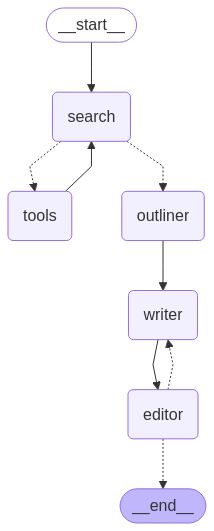

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [14]:
from langchain_core.messages import HumanMessage


thread = {"configurable": {"thread_id": "1"}}

MAX_ITERATIONS = 3

question = "Jaki jest potencjał wykorzystania technologii generatywnych w bankowości? Zaproponuj scenariusze użycia i przykładowe uzasadnienia biznesowe."
input_message = HumanMessage(content=question)

for event in graph.stream({"messages": [input_message], "no_of_iterations":0}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Jaki jest potencjał wykorzystania technologii generatywnych w bankowości? Zaproponuj scenariusze użycia i przykładowe uzasadnienia biznesowe.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ELbYoqf0YNToRIOSKYW0uMe2)
 Call ID: call_ELbYoqf0YNToRIOSKYW0uMe2
  Args:
    query: generative technology in banking potential use cases
  tavily_search_results_json (call_E68Dig3Y8xAVupS2THMw56EC)
 Call ID: call_E68Dig3Y8xAVupS2THMw56EC
  Args:
    query: generative AI in banking business justification
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What is generative AI in banking? - IBM", "url": "https://www.ibm.com/think/topics/generative-ai-banking", "content": "In investment banking, generative AI can compile and analyze financial data to create detailed p

# Human in the loop

In [15]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph = workflow.compile(checkpointer=checkpointer, interrupt_before=['editor'])

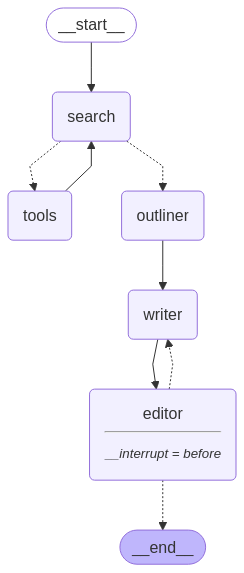

In [16]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "1"}}

MAX_ITERATIONS = 3

question = "What is the business potential of multi-agent systems based on large language models?"
input_message = HumanMessage(content=question)

for event in graph.stream({"messages": [input_message], "no_of_iterations":0}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the business potential of multi-agent systems based on large language models?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_b7Vw9EIVvlJZriuoUREmnFKk)
 Call ID: call_b7Vw9EIVvlJZriuoUREmnFKk
  Args:
    query: business potential of multi-agent systems based on large language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "How Multi-Agent LLMs Working Together Will Impact Business", "url": "https://www.forbes.com/councils/forbesbusinessdevelopmentcouncil/2023/11/28/how-multi-agent-llms-working-together-will-impact-business/", "content": "Our journey through the emerging world of multi-agent large language models reveals a landscape teeming with excitement and potential. From redefining the customer experience to driving global collabo

In [18]:
graph.update_state(thread, {"messages": HumanMessage(content="For the article sections, write in paragraph format and don't copy the outline. Keep the sources at the bottom of the article. Include information about the most popular multi-agent frameworks")}, as_node="editor")

Iteration number from should_edit:  0


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f021ce9-ab63-688a-8006-6616bba818b3'}}

In [19]:
graph.get_state(thread).next

('writer',)

In [20]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
     event["messages"][-1].pretty_print()

================================ Human Message =================================

For the article sections, write in paragraph format and don't copy the outline. Keep the sources at the bottom of the article. Include information about the most popular multi-agent frameworks
================================== Ai Message ==================================

                        TITLE: The Business Potential of Multi-Agent Systems Based on Large Language Models
                        
                        BODY: 
                        
In the rapidly evolving landscape of artificial intelligence, multi-agent systems (MAS) and large language models (LLMs) are emerging as powerful tools that can transform business operations. Multi-agent systems consist of multiple interacting intelligent agents that collaborate to solve complex problems, while large language models are advanced AI systems capable of understanding and generating human-like text. This article explores the business pot

In [21]:
# continue without any further comments
graph.update_state(thread, {"messages": HumanMessage(content="")}, as_node="editor")
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
     event["messages"][-1].pretty_print()

Iteration number from should_edit:  0
================================ Human Message =================================


================================== Ai Message ==================================

It seems that your message was empty. If you have any questions, feedback, or requests for further information, please let me know! I'm here to help.
